- We will use a Convolutional Neural Network to identify transcription factor binding sites in DNA Sequences
- The convolutional layer scans small regions of the input data, known as the receptive field or kernel
- This allows it to capture local patterns and features.
- We reuse a tutorial from a [publication](https://www.nature.com/articles/s41588-018-0295-5) that gives an introduction about deep learning applications for genome analysis.
- The tutorial is structured as follows:
    - Introduction and first look at input data
    - Data curation (bring the data in a form that can be processed by our model)
    - Select the architecture and train the model
    - Evaluate the model

## Introduction and first look at input data
- 2000 DNA sequences (each has a length of 50 nucleotides) 
- each sequence is labeled depending on its abilitiy to bind to a protein (transcription factor), we pretend this is the result of a binding assay
- If a seqeunce does NOT bind it gets the label 0 and if it binds it gets the label 1
- Each binding sequence has the regulatory motif *CGACCGAACTCC* somwhere in its sequence embedded

### We start by loading the simulated data from an external repository

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests



In [2]:
sequences_url = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(sequences_url).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


### Read in data from file (alternative if the data can not be loaded from the repository)

In [3]:
with open("sequences.txt") as f:
    sequences = f.read()

sequences = sequences.split('\n')

sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()


,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


## Organize the data into a format that can be passed into a deep learning algorithm

- Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors).

- To get each DNA sequence in the form of a matrix, we use one-hot encoding

- One-hot endocing encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. 

- We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.




### Show how a single sequences in one-hot encoded

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()

# One-hot encodes a series of integers
one_hot_encoder = OneHotEncoder(categories='auto')



# Take a single sequence to demonstrate step-by-step what one-hot encoding does
sequence = sequences[0]
# Out sequence is a string that we transform to a list and feed it to the integer encoder
print(sequence[:10])
integer_encoded = integer_encoder.fit_transform(list(sequence))
print(integer_encoded[:10])
# A = 0, C = 1, G = 2, T = 3

#### continue to convert integers to sparse matrix
integer_encoded = np.array(integer_encoded).reshape(-1, 1)
print(integer_encoded[:10])

# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
#### one-hot encode the array
one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
print(one_hot_encoded.toarray()[:10])

CCGAGGGCTA
[1 1 2 0 2 2 2 1 3 0]
[[1]
 [1]
 [2]
 [0]
 [2]
 [2]
 [2]
 [1]
 [3]
 [0]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


### One-hot encode each sequence in a for-loop

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

# convert the list of input arrays to an array of arrays
input_features = np.stack(input_features)
print(input_features.shape)


(2000, 50, 4)


## Load and encode the labels 
- the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. 
- While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features.

In [5]:
labels_url = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(labels_url).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences



### Read in data from file (alternative if the data can not be loaded from the repository)

In [6]:
with open("labels.txt") as f:
    labels = f.read()
    
labels = labels.split('\n')
labels = list(filter(None, labels))  # removes empty sequences
    



In [7]:
one_hot_encoder = OneHotEncoder(categories='auto')

# The labels are organized in a list
print(labels)

# convert them to an array
labels = np.array(labels).reshape(-1, 1)
print(labels)
# One one-hot encode the labels
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print(input_labels)



['0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0',

# Select the architecture and train the model

### Split the data into training and test sets. 
- The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. 
- At a later step, we will further partition the training set into a training and validation set.

(1) Training dataset: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

(2) Validation dataset: The weights of the network are not adjusted with this data set, however the set can be used to observe if the model is overfitting.

(3) Testing dataset: is a third dataset not included in the training nor validation data sets.
Used to measure the performance on new examples.

In [9]:
# Split data into train and test set (train test will later be split into train and validation set)
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

### Select the Architecture and Train

- Next, we choose a neural network architecture to train the model. 

- we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

- A CNN learns to recognize sequence patterns by trying to match the input sequence to a number of learnable "filters" of a fixed size



- We will use the deep learning library `Keras`, which  has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks.
- We only need to specify the kinds of layers we would like to include in our network, and the dimensionality of each layer: 

The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters and a kernel size of 12.

- _MaxPooling1D_: After the convolution, we use a pooling layer of step-size 4 to down-sample the output of the each of the 32 convolutional filters. (Though not always required, this is a typical form of non-linear down-sampling used in CNNs.)

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters.

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors

- The second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

- We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network.

In [10]:
# Keras is a high level api for tensorflow
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12,
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
# Softmax function: often used for last layer, since all probablities for all classes sum up to 1 when using softmax
model.add(Dense(2, activation='softmax'))

# adam is a gradient descent based optimizer for finding the weights
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])

# We can see the details of the architecture of the neural network we have created by running `model.summary()`
# which prints the dimensionality and number of parameters for each layer in our network.
model.summary()

2024-04-02 14:45:28.602989: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 14:45:28.891206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 14:45:28.891310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 14:45:28.934570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 14:45:29.029446: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 14:45:29.030829: I tensorflow/core/platform/cpu_feature_guard.cc:1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 16)                4624      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 6226 (24.32 KB)
Trainable params: 6226 (24.32 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters and a kernel size of 12.

- _MaxPooling1D_: After the convolution, we use a pooling layer of step-size 4 to down-sample the output of the each of the 32 convolutional filters. (Though not always required, this is a typical form of non-linear down-sampling used in CNNs.)

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters.

- _Dense_: The first Dense function creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors

- The second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

- We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network.

(show the cnn.png figure to explain the layers)

### Train the model
- train the neural network
- further divide the training set into a training and validation set.
- the training runs for 50 epochs. Epochs are the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.
- The model's performance metrics, such as accuracy, loss, or other evaluation metrics, are computed on the validation set after each training epoch or iteration
- The validation set does not influence the training behaviour, but might influence the person designing the model
- Thereby the validation set has an indirect influence on the model itself
- Therfore after training the model, a third dataset, the test data set is used to measure the models performance on unseen data, that had absolutely no influence on the model



In [11]:
history = model.fit(train_features, train_labels,
                    epochs=50, verbose=0, validation_split=0.25)



## BCE = Binary Cross Entropy
- Now we have a look how well the model generalizes to unseen data during training
- We use the validation set for evaluation
- We use to different metrics that show us how well the model works predicting the correct labels

- First the loss function where we use binary crossentropy

- For each example in the dataset, you have a true binary label, typically denoted as either 0 or 1, where 0 represents one class, and 1 represents the other class.

- You also have a predicted probability associated with each example, typically produced by the softmax activation function. This predicted probability represents the model's confidence that the example belongs to class 1 (for a binary classification). The values are between 0 and 1.



### BCE tells you how confident the model is in its predictions, it is the log of the predicted probabilities


- The BCE loss is computed for each example and then averaged over the entire dataset.

- If the true label is 1 (indicating the positive class), the loss for that example is:
  
  BCE = -log(predicted_probability)
  

- If the true label is 0 (indicating the negative class), the loss for that example is:
  
  BCE = -log(1 - predicted_probability)




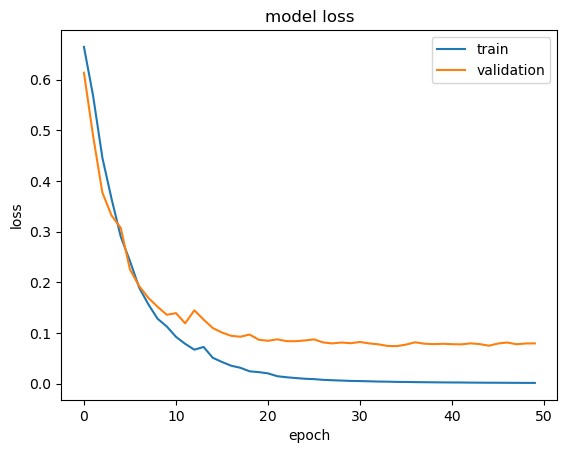

In [12]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

Binary Accuracy = (Number of Correctly Predicted Examples) / (Total Number of Examples)

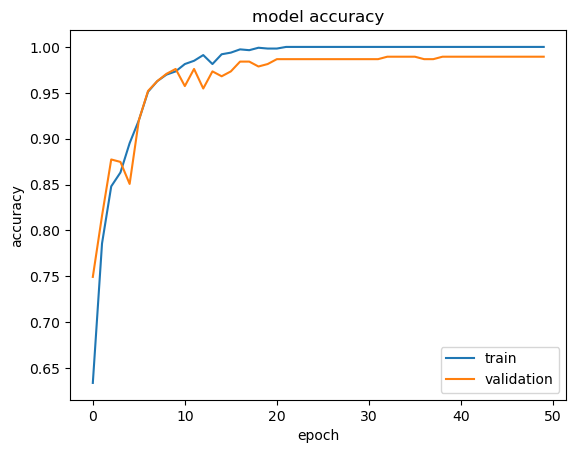

In [13]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Evaluate the model

- Evaluate the model on a fresh test set consisting of data that it has not observed at all during training.
- We plot the results as a confusion matrix

16/16 [==============================] - 0s 993us/step
[[1.3557021e-11 9.9999994e-01]
 [9.9999994e-01 8.0117857e-11]
 [1.5464387e-08 9.9999994e-01]
 [6.6236773e-13 9.9999994e-01]
 [9.9999994e-01 2.2414774e-10]
 [9.9999994e-01 9.4869173e-12]
 [4.0231013e-12 9.9999994e-01]
 [9.9999994e-01 3.1321551e-12]
 [5.8852606e-07 9.9999934e-01]
 [2.1823710e-09 9.9999994e-01]]
[1 0 1 1 0 0 1 0 1 1]
Confusion matrix:
 [[254   5]
 [  2 239]]
[[259]
 [241]]
[[0.98069498 0.01930502]
 [0.00829876 0.99170124]]


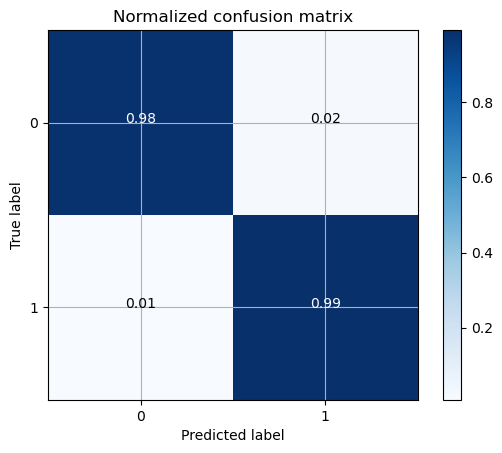

In [14]:
from sklearn.metrics import confusion_matrix
import itertools


############

# predict the labels of the test data using our trained model
predicted_labels = model.predict(test_features)
# show the actual probaility values of the prediction
print(predicted_labels[:10])
# turn the value into 0 and 1 to get the labels
print(np.argmax(predicted_labels[:10], axis=1))

############################

# Build a confusion matrix with the true labels and the predicted values
cm = confusion_matrix(np.argmax(test_labels, axis=1),
                      np.argmax(predicted_labels, axis=1))



# The confusion matrix looks as follows:
print('Confusion matrix:\n',cm)
# 251 True negatives, 8 False positives, 1 False negative , 240 True positives

##### now we devide the correctly and incorrectly labeld sequences 
#by the total number of the the sequences of that label
print(cm.sum(axis = 1)[:, np.newaxis])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
print(cm)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

### True positive rate (sensitivity, recall)
TNR: specificity, selectivity or true negative rate TN / (TN + FP)
What percentages of sequences not binding could be identified as such.
0.97

FPR: fall-out or false positive rate  FP / (FP + TN)
What percentages of sequences not binding could NOT be identified as such.
0.03

FNR: miss rate or false negative rate FN / (FN + TP)
What percentages of all binding motifs could NOT be identified as such
0.01

TPR: sensitivity, recall, hit rate, or true positive rate TP / (FN + TP)
What percentages of all binding motifs could be identified as such.
0.99






